In [5]:
%matplotlib inline

import sys
from time import time
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.feature_selection import mutual_info_regression

import tensorflow as tf
tf.autograph.set_verbosity(0, True)
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (Dense, 
                                     Flatten, 
                                     Conv1D, 
                                     MaxPooling1D, 
                                     Dropout, 
                                     BatchNormalization)

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
from utils import MultipleTimeSeriesCV, format_time

In [8]:
np.random.seed(666)
tf.random.set_seed(666)

In [9]:
sns.set_style('whitegrid')

In [11]:
results_path = Path('/Users/luzhang/Documents/GitHub/Deep-Learning-Models/CNNs/CNN_with_time_series_data', 'cnn_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

### Prepare Data

In [12]:
prices = (pd.read_hdf('/Users/luzhang/Documents/GitHub/Deep-Learning-Models/Data/assets.h5', 'quandl/wiki/prices')
          .adj_close
          .unstack().loc['2000':])
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4706 entries, 2000-01-03 to 2018-03-27
Columns: 3199 entries, A to ZUMZ
dtypes: float64(3199)
memory usage: 114.9 MB


#### Compute montly returns

In [14]:
returns = (prices
           .resample('M')
           .last()
           .pct_change()
           .dropna(how='all')
           .loc['2000': '2017']
           .dropna(axis=1)
           .sort_index(ascending=False))

# remove outliers likely representing data errors
returns = returns.where(returns<1).dropna(axis=1)
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 215 entries, 2017-12-31 to 2000-02-29
Freq: -1M
Columns: 1511 entries, A to ZQK
dtypes: float64(1511)
memory usage: 2.5 MB


#### Create model data

In [15]:
n = len(returns)
nlags = 12
lags = list(range(1, nlags + 1))

In [20]:
cnn_data = []
for i in range(n-nlags-1):
    df = returns.iloc[i:i+nlags+1]        # select outcome and lags
    date = df.index.max()                 # use outcome date
    cnn_data.append(df.reset_index(drop=True)  # append transposed series
                    .transpose()
                    .assign(date=date)
                    .set_index('date', append=True)
                    .sort_index(axis=1))

cnn_data = (pd.concat(cnn_data)
            .rename(columns={0: 'label'})
            .sort_index())

cnn_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 305222 entries, ('A', Timestamp('2001-03-31 00:00:00')) to ('ZQK', Timestamp('2017-12-31 00:00:00'))
Data columns (total 13 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   label   305222 non-null  float64
 1   1       305222 non-null  float64
 2   2       305222 non-null  float64
 3   3       305222 non-null  float64
 4   4       305222 non-null  float64
 5   5       305222 non-null  float64
 6   6       305222 non-null  float64
 7   7       305222 non-null  float64
 8   8       305222 non-null  float64
 9   9       305222 non-null  float64
 10  10      305222 non-null  float64
 11  11      305222 non-null  float64
 12  12      305222 non-null  float64
dtypes: float64(13)
memory usage: 31.5+ MB


In [21]:
cnn_data.head()

label         1         2         3         4         5  \
ticker date                                                                     
A      2001-03-31 -0.146389 -0.340055 -0.003653  0.049052  0.126970 -0.053739   
       2001-04-30  0.269444 -0.146389 -0.340055 -0.003653  0.049052  0.126970   
       2001-05-31 -0.140220  0.269444 -0.146389 -0.340055 -0.003653  0.049052   
       2001-06-30 -0.031008 -0.140220  0.269444 -0.146389 -0.340055 -0.003653   
       2001-07-31 -0.119692 -0.031008 -0.140220  0.269444 -0.146389 -0.340055   

                          6         7         8         9        10        11  \
ticker date                                                                     
A      2001-03-31 -0.197705  0.496933 -0.447458  0.001630 -0.169243 -0.147788   
       2001-04-30 -0.053739 -0.197705  0.496933 -0.447458  0.001630 -0.169243   
       2001-05-31  0.126970 -0.053739 -0.197705  0.496933 -0.447458  0.001630   
       2001-06-30  0.049052  0.126970 -0.053739 -0.197705  0.496933 -0.447458   
       2001-07-31 -0.003653  0.049052  0.126970 -0.053739 -0.197705  0.496933   

                         12  
ticker date                  
A      2001-03-31  0.000962  
       2001-04-30 -0.147788  
       2001-05-31 -0.169243  
       2001-06-30  0.001630  
       2001-07-31 -0.447458

### Evaluate features

#### Mutual Information

In [22]:
mi = mutual_info_regression(X=cnn_data.drop('label', axis=1), y=cnn_data.label)
mi = pd.Series(mi, index=cnn_data.drop('label', axis=1).columns)

### Information Coefficient

In [33]:
ic = {}

for lag in lags:
    ic[lag] = spearmanr(cnn_data.label, cnn_data[lag])

ic = pd.DataFrame(ic, index=['IC', 'p-value']).T

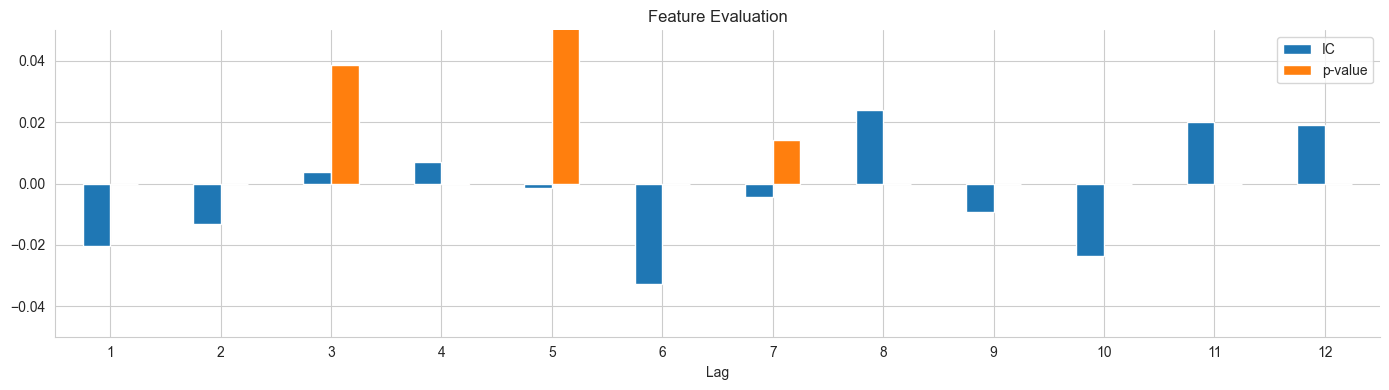

In [36]:
 ax = ic.plot.bar(rot=0, figsize=(14, 4),
                  ylim=(-0.05, .05),
                  title='Feature Evaluation')
 ax.set_xlabel('Lag')
 sns.despine()
 plt.tight_layout()
 plt.savefig(results_path / 'cnn_ts1d_feature_ic', dpi=300)

#### Plot Metrics

In [42]:
 metrics = pd.concat([mi.to_frame('Mutual Information'),
                     ic.IC.to_frame('Information Coefficient')], axis=1)

In [43]:
metrics

,Mutual Information,Information Coefficient
1,0.101298,-0.020365
2,0.091650,-0.013307
3,0.092065,0.003743
4,0.083636,0.006940
5,0.074384,-0.001615
6,0.076060,-0.032920
7,0.064097,-0.004442
8,0.061729,0.023948
9,0.061000,-0.009403
10,0.054664,-0.023577


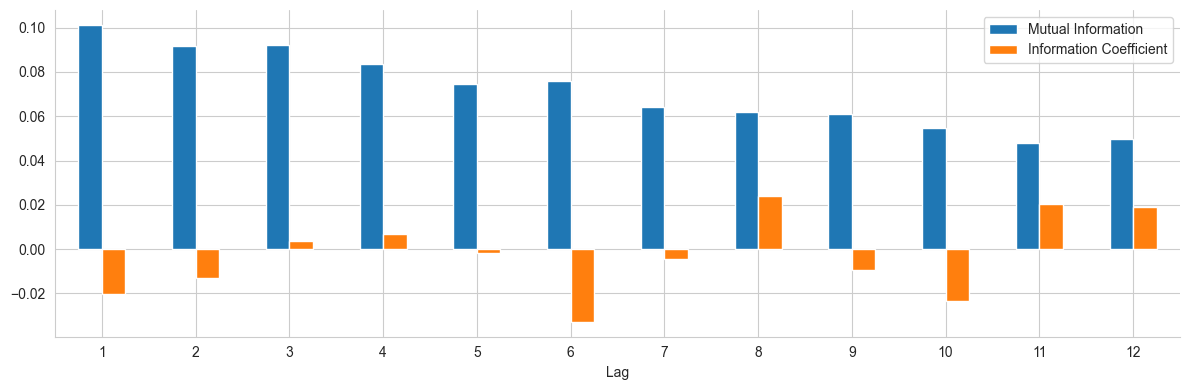

In [44]:
 ax = metrics.plot.bar(figsize=(12, 4), rot=0)
 ax.set_xlabel('Lag')
 sns.despine()
 plt.tight_layout()
 plt.savefig(results_path / 'ts1d_metrics', dpi=300)

### CNN

#### Model Architecture

In [45]:
def get_model(filters=32, kernel_size=5, pool_size=2):
    model = Sequential([Conv1D(filters=filters,
                               kernel_size=kernel_size,
                               activation='relu',
                               padding='causal',
                               input_shape=input_shape,
                               use_bias=True,
                               kernel_regularizer=regularizers.l1_l2(l1=1e-5,
                                                                     l2=1e-5)),
                        MaxPooling1D(pool_size=pool_size),
                        Flatten(),
                        BatchNormalization(),
                        Dense(1, activation='linear')])
    model.compile(loss='mse',
                  optimizer='Adam')
    return model

#### Set up CV

In [46]:
cv = MultipleTimeSeriesCV(n_splits=12 * 3,
                          train_period_length=12 * 5,
                          test_period_length=1,
                          lookahead=1)

In [47]:
input_shape = nlags, 1

#### Train Model

In [48]:
def get_train_valid_data(X, y, train_idx, test_idx):
    x_train, y_train = X.iloc[train_idx, :], y.iloc[train_idx]
    x_val, y_val = X.iloc[test_idx, :], y.iloc[test_idx]
    m = X.shape[1]
    return (x_train.values.reshape(-1, m, 1), y_train,
            x_val.values.reshape(-1, m, 1), y_val)

In [50]:
batch_size = 64
epochs = 100

In [51]:
filters = 32
kernel_size = 4
pool_size = 4

In [52]:
get_model(filters=filters,
          kernel_size=kernel_size, 
          pool_size=pool_size).summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 12, 32)            160       
                                                                 
 max_pooling1d (MaxPooling1  (None, 3, 32)             0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 96)                0         
                                                                 
 batch_normalization (Batch  (None, 96)                384       
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 1)                 97        
                                                                 
Total params: 641 (2.50 KB)
Trainable params: 449 (1.75 

#### Cross-validation loop

In [53]:
result = {}
start = time()
for fold, (train_idx, test_idx) in enumerate(cv.split(cnn_data)):
    X_train, y_train, X_val, y_val = get_train_valid_data(cnn_data
                                                          .drop('label', axis=1)
                                                          .sort_index(ascending=False),
                                                          cnn_data.label,
                                                          train_idx,
                                                          test_idx)
    test_date = y_val.index.get_level_values('date').max()
    model = get_model(filters=filters,
                      kernel_size=kernel_size,
                      pool_size=pool_size)
    
    best_ic = -np.inf
    stop = 0
    for epoch in range(50):         
        training = model.fit(X_train, y_train,
                             batch_size=batch_size,
                             validation_data=(X_val, y_val),
                             epochs=epoch + 1,
                             initial_epoch=epoch,
                             verbose=0,
                             shuffle=True)
        predicted = model.predict(X_val).squeeze()
        ic, p_val_ = spearmanr(predicted, y_val)
        if ic > best_ic:
            best_ic = ic
            p_val = p_val_
            stop = 0
        else:
            stop += 1
        if stop == 10:
            break
    
    nrounds = epoch + 1 - stop
    result[test_date] = [nrounds, best_ic, p_val]
    df = pd.DataFrame(result, index=['epochs', 'IC', 'p-value']).T
    msg = f'{fold + 1:02d} | {format_time(time()-start)} | {nrounds:3.0f} | '
    print(msg + f'{best_ic*100:5.2} ({p_val:7.2%}) | {df.IC.mean()*100:5.2}')

48/48 [==============================] - 0s 730us/step
01 | 00:00:28 |   4 |   7.0 (  0.65%) |   7.0
48/48 [==============================] - 0s 643us/step
02 | 00:00:49 |   1 |   1.1 ( 67.76%) |   4.0
48/48 [==============================] - 0s 672us/step
03 | 00:01:10 |   1 | -0.81 ( 75.30%) |   2.4
48/48 [==============================] - 0s 747us/step
04 | 00:02:00 |  16 |   1.4 ( 57.46%) |   2.2
48/48 [==============================] - 0s 694us/step
05 | 00:02:20 |   1 | -0.13 ( 96.06%) |   1.7
48/48 [==============================] - 0s 713us/step
06 | 00:02:40 |   1 |   1.1 ( 66.35%) |   1.6
48/48 [==============================] - 0s 681us/step
07 | 00:03:18 |  11 |   2.4 ( 34.69%) |   1.7
48/48 [==============================] - 0s 692us/step
08 | 00:04:05 |  16 |   3.4 ( 18.65%) |   1.9
48/48 [==============================] - 0s 781us/step
09 | 00:04:25 |   1 |  0.27 ( 91.69%) |   1.8
48/48 [==============================] - 0s 689us/step
10 | 00:04:46 |   2 |   5.0 (  5.39%

#### Evaluate Results

In [54]:
metrics = pd.DataFrame(result, index=['epochs', 'IC', 'p-value']).T

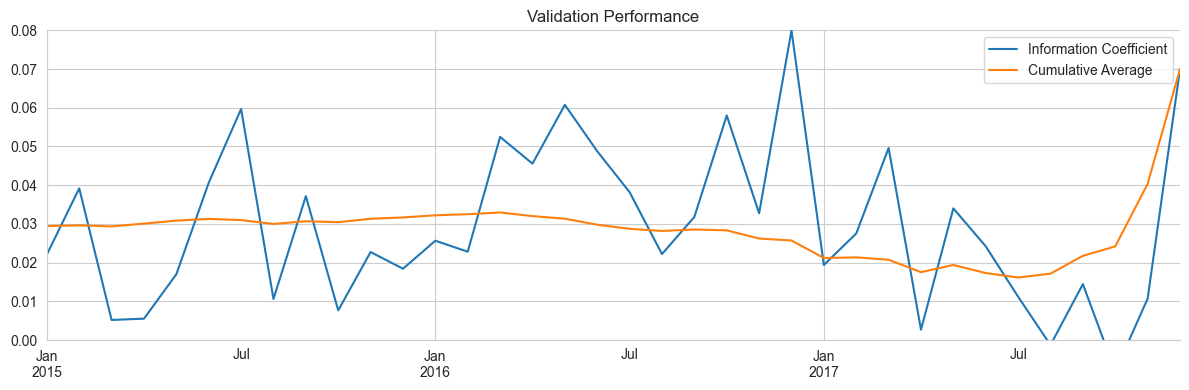

In [55]:
ax = metrics.IC.plot(figsize=(12, 4), 
                     label='Information Coefficient',
                     title='Validation Performance',
                    ylim=(0, .08))
metrics.IC.expanding().mean().plot(ax=ax, label='Cumulative Average')
plt.legend()
sns.despine()
plt.tight_layout()
plt.savefig(results_path / 'cnn_ts1d_ic', dpi=300);